In [1]:
import random
from abc import ABCMeta, abstractmethod

import numpy as np
import matplotlib.pyplot as plt


In [133]:
class Task:
    def __init__(self, uid, create_time, exe_time, priority=None, deadline=None):
        self.id = uid
        self.create_time = create_time
        self.exe_time = exe_time
        self.exe_remain = exe_time
        self.deadline = deadline
        self.priority = priority
        self.exe_start = None
        self.exe_finish = None
        self.completed = False
        self.wait_time = 0
        
    def exe_tick(self, sys_time):
        if self.exe_time == self.exe_remain:
            self.exe_start = sys_time
            self.wait_time = sys_time - self.create_time
            
        self.exe_remain -= 1
        if self.exe_remain == 0:
            self.completed = True
            self.exe_finish = sys_time
            
    def __eq__(self, other):
        return self.id == other.id
             
    def __str__(self):
        return f"Task {self.id} Creation time = {self.create_time} " + \
               f"exe_time = {self.exe_time} Deadline = {self.deadline}"
        
    def __repr__(self):
        return f"Task {self.id}"
         

In [96]:
class Generator(metaclass=ABCMeta):
    def __init__(self, min_exe_time, max_exe_time):
        self.initial_id = 0
        self.max_time = max_exe_time
        self.min_time = min_exe_time
     
    def generate_task(self, curr_time, deadline_coef=2):
        
        exe_time = random.randint(self.min_time, self.max_time + 1)
        deadline = curr_time + exe_time \
                    + random.randint(exe_time, deadline_coef * exe_time)
        task = Task(self.initial_id, curr_time, exe_time, deadline=deadline)
        self.initial_id += 1
        return task
    
    @abstractmethod    
    def generate_tasks(self, curr_time):
        tasks = []
        return tasks
        
        
class UniformGenerator(Generator):
    def __init__(self, min_exe_time, max_exe_time, tasks_range=(0, 3)):
        """
        :param tuple[int] tasks_range: min and max number of generated tasks per timestep
        """
        Generator.__init__(self, min_exe_time, max_exe_time)
        self.range = tasks_range
        
    def generate_tasks(self, curr_time):
        tasks = []
        n_create = random.randint(self.range[0], self.range[1])
        for i in range(n_create):
            tasks.append(self.generate_task(curr_time))
        return tasks
    

class ErlangGenerator(Generator):
    def __init__(self, min_exe_time, max_exe_time, shape_param=1.5, scale_param=1):
        """
        :param tuple[int] tasks_range: min and max number of generated tasks per timestep
        """
        Generator.__init__(self, min_exe_time, max_exe_time)
        self.shape_param = shape_param
        self.scale_param = scale_param
        
    def generate_tasks(self, curr_time):
        tasks = []
        n_create = int(random.gammavariate(self.shape_param, self.scale_param))
        for i in range(n_create):
            tasks.append(self.generate_task(curr_time))
        return tasks
    

In [97]:
class SimpleGenerator(Generator):
    def __init__(self, min_exe_time, max_exe_time, intensity=0.1):
        Generator.__init__(self, min_exe_time, max_exe_time)
        self.intensity = intensity
        
    def generate_task(self, curr_time):
        chance = random.random()
        if chance < self.intensity:
            exe_time = random.randint(self.min_time, self.max_time + 1)
            deadline = curr_time + exe_time + random.randint(exe_time,
                                                             2 * exe_time)
            
            task = Task(self.initial_id, curr_time, exe_time, deadline=deadline)
            self.initial_id += 1
            return task
        return None
    

In [175]:
class Queue(metaclass=ABCMeta):
    
    def __init__(self):
        self._queue = []
        self._len = 0 
    
    @property
    def queue(self):
        return self._queue
        
    @property
    def len(self):
        return self._len
    
    @abstractmethod
    def push_task(self):
        None
    
    @abstractmethod
    def get_task(self):
        None
        
    def push_tasks(self, tasks):
        for task in tasks:
            self.push_task(task)
    

class FIFO(Queue):
    
    def __init__(self):
        Queue.__init__(self)
    
    def push_task(self, task):
        if isinstance(task, Task):
            self._queue.append(task)
            self._len += 1
        
    def get_task(self):
        if self._len == 0:
            return None
        else:
            self._len -= 1
            return self._queue.pop(0)
        
        
class LIFO(Queue):
    
    def __init__(self):
        Queue.__init__(self)
    
    def push_task(self, task):
        self._queue.append(task)
        self._len += 1
        
    def get_task(self):
        if self._len == 0:
            return None
        else:
            self._len -= 1
            return self._queue.pop(self.len)        
               
            
class EDF(Queue):
    
    def __init__(self):
        Queue.__init__(self)
        self.deadlines = []

    def push_task(self, task):
        if isinstance(task, Task):
            self._queue.append(task)
            self._len += 1
            self.deadlines.append(task.deadline)
            
    def get_task(self):
        if self._len == 0:
            return None
        else:
            self._len -= 1
            early_deadline = min(self.deadlines)
            index = self.deadlines.index(early_deadline)
            task = self._queue.pop(index)
            _ = self.deadlines.pop(index)
            return task


In [176]:
class Processor:
    
    def __init__(self):
        self.sys_time = 0
        self.is_free = True
        self.curr_tasks = []
        
    def set_task(self, task):
        if isinstance(task, Task) and self.is_free:
            self.curr_tasks.append(task)
            self.is_free = len(self.curr_tasks) < 1
        
    def run_tick(self):
        """
        :return list[Task] currents:
        :return list[Task] completed:
        :return list[Task] back_to_queue: на случай прерываний
        """
        self.sys_time += 1
        currents = []
        completed = []
        back_to_queue = []
        
        for task in self.curr_tasks:
            task.exe_tick(self.sys_time)
            if task.completed:
                completed.append(task)
            else:
                currents.append(task)
                
        self.curr_tasks = currents
        self.is_free = len(self.curr_tasks) < 1
        return currents, completed, back_to_queue
    
    def drop_task(self, task):
        for curr_task in self.curr_tasks:
            if curr_task == task:
                self.curr_tasks.remove(task)
    

In [177]:
class RTS_sheduler:
    def __init__(self, generator, queue, processor):
        self.gen = generator
        self.queue = queue
        self.proc = processor
        self.sys_time = 0
        self.completed_tasks = []
        self.dropped_tasks = []
        self.created_tasks = []
        
    def simulate_steps(self, n_steps):
        
        for i in range(n_steps):
            new_tasks = self.gen.generate_tasks(self.sys_time)
            self.created_tasks += new_tasks
            self.queue.push_tasks(new_tasks)
          #  print("STEP", i, "Created", new_tasks)
            
            while self.proc.is_free and self.queue.len > 0:
                t = self.queue.get_task()
                if t.deadline < (self.sys_time + t.exe_remain):
           #         print("Dropped", t)
                    self.dropped_tasks.append(t)
                else:
           #         print("Proc", t)
                    self.proc.set_task(t)
                
            currents, completed, back_to_q = self.proc.run_tick()
         #  if len(completed) > 0:
         #       print("Completed", completed)
            self.completed_tasks += completed
            self.sys_time += 1

In [170]:
g = ErlangGenerator(0, 3, shape_param=1)
q = LIFO()
p = Processor()

rts = RTS_sheduler(g, q, p)
rts.simulate_steps(100)

STEP 0 Created []
STEP 1 Created []
STEP 2 Created []
STEP 3 Created []
STEP 4 Created []
STEP 5 Created [Task 0, Task 1]
Proc Task 1 Creation time = 5 exe_time = 1 Deadline = 8
Completed [Task 1]
STEP 6 Created []
Dropped Task 0 Creation time = 5 exe_time = 0 Deadline = 5
STEP 7 Created []
STEP 8 Created []
STEP 9 Created []
STEP 10 Created []
STEP 11 Created [Task 2, Task 3]
Proc Task 3 Creation time = 11 exe_time = 1 Deadline = 14
Completed [Task 3]
STEP 12 Created [Task 4, Task 5, Task 6, Task 7]
Proc Task 7 Creation time = 12 exe_time = 4 Deadline = 23
STEP 13 Created []
STEP 14 Created []
STEP 15 Created []
Completed [Task 7]
STEP 16 Created []
Dropped Task 6 Creation time = 12 exe_time = 1 Deadline = 15
Dropped Task 5 Creation time = 12 exe_time = 0 Deadline = 12
Proc Task 4 Creation time = 12 exe_time = 4 Deadline = 20
STEP 17 Created [Task 8]
STEP 18 Created []
STEP 19 Created []
Completed [Task 4]
STEP 20 Created []
Proc Task 8 Creation time = 17 exe_time = 2 Deadline = 22
ST

In [178]:
g = ErlangGenerator(1, 3, shape_param=1)
q = EDF()
p = Processor()

rts = RTS_sheduler(g, q, p)
rts.simulate_steps(100)

In [179]:
len(rts.completed_tasks)

40

In [180]:
len(rts.dropped_tasks)

28

In [181]:
len(rts.created_tasks)

69

In [182]:
rts.proc.curr_tasks

[]

In [85]:
a = [int(random.gammavariate(1.5, 1)) for i in range(10000)]

In [58]:
a = np.random.gamma(3, 1, size=10000)

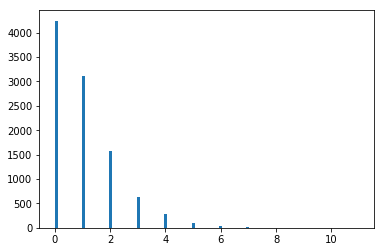

In [86]:
plt.hist(a, bins=100)
plt.show()